In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import classification_report, roc_auc_score ,r2_score ,mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.ensemble import RandomForestRegressor ,RandomForestClassifier ,GradientBoostingRegressor ,StackingRegressor
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor 
from sklearn.linear_model import Ridge ,LinearRegression, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
pd.set_option('display.max_columns', None)
test_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
df.replace('(not set)', np.nan, inplace=True)
test_df.replace('(not set)', np.nan, inplace=True)

In [4]:
test_stack = test_df.copy()
test_stack.shape

(29006, 51)

In [5]:
y = df.iloc[:, 1]      # second column as target
X = df.drop(df.columns[1], axis=1)  # drop second column from features

print('X - shape :', X.shape)
print('y - shape :', y.shape)

X - shape : (116023, 51)
y - shape : (116023,)


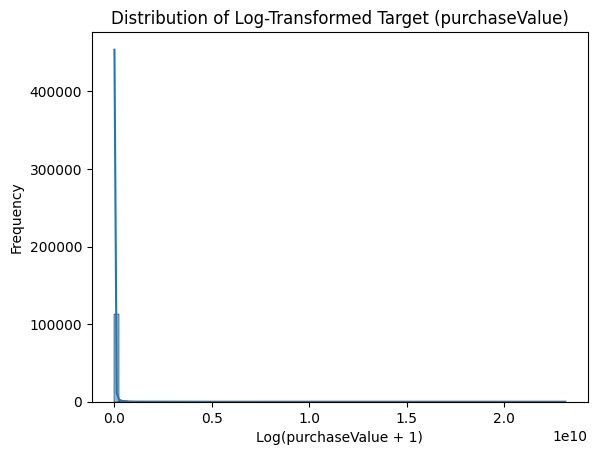

Zero purchase values: 92038
Non-zero purchase values: 23985
Total samples: 116023


In [6]:
sns.histplot(y, bins=100, kde=True)
plt.title("Distribution of Log-Transformed Target (purchaseValue)")
plt.xlabel("Log(purchaseValue + 1)")
plt.ylabel("Frequency")
plt.show()

# Let's also see how many are zeros
print("Zero purchase values:", (y == 0).sum())
print("Non-zero purchase values:", (y != 0).sum())
print("Total samples:", len(y))

**~79% of data has zero purchaseValue (92,038 out of 116,023). That’s huge!**
Trying to predict a continuous variable (purchaseValue) using regression. But if most values are zero, the model is learning “just predict zero” as the safest bet — which is why your R² is low. It’s overwhelmed by the imbalance.

In [7]:
# Add binary target column for classification
df['made_purchase'] = (df['purchaseValue'] > 0).astype(int)

# Check balance
df['made_purchase'].value_counts(normalize=True)

made_purchase
0    0.793274
1    0.206726
Name: proportion, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('X_train - shape : ',X_train.shape)
print('X_test - shape : ',X_test.shape)
print('y_train - shape : ',y_train.shape)
print('y_test - shape : ',y_test.shape)

X_train - shape :  (87017, 51)
X_test - shape :  (29006, 51)
y_train - shape :  (87017,)
y_test - shape :  (29006,)


In [9]:
# num_cols = X.select_dtypes(include=['int64','float64']).columns
# cat_cols = X.select_dtypes(include=['object']).columns
# log_cols = ['pageViews', 'totalHits']
# # Imputers
# # FunctionTransformer for log1p
# log_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('log', FunctionTransformer(np.log1p, validate=True))
# ])

# # Imputer for numerical (excluding log columns)
# num_imputer = SimpleImputer(strategy='mean')
# # Pipeline for numerical columns
# num_pipeline = Pipeline([
#     ('imputer', num_imputer)
# ])
# cat_imputer = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))
# ])
# # Preprocessor
# preprocessor = ColumnTransformer(transformers=[
#     ('num', num_pipeline, num_cols),
#     ('cat', cat_imputer, cat_cols),
#     ('log', log_pipeline, log_cols)  # log-transform pageViews, totalHits
# ])

# New flow 

**Classifier Part**

In [10]:
# # Define target for classifier
# y_class = df['made_purchase']
# X_class = df.drop(columns=['purchaseValue', 'made_purchase'])

# # Train-test split
# X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_class, y_class, test_size=0.25, random_state=42, stratify=y_class)

# # Reuse your preprocessor pipeline
# pipeline_classifier = Pipeline([
#     ('preprocessing', preprocessor),
#     ('model', RandomForestClassifier(random_state=42))
# ])

# # Train classifier
# pipeline_classifier.fit(X_train_cls, y_train_cls)

# # Evaluate
# print('X_test shape : ', X_test_cls.shape)
# y_pred_cls = pipeline_classifier.predict(X_test_cls)
# print('y_pred shape : ', y_pred_cls.shape)
# y_proba_cls = pipeline_classifier.predict_proba(X_test_cls)[:, 1]
# print('y_proba_cls shape : ', y_proba_cls.shape)

# print(classification_report(y_test_cls, y_pred_cls))
# print("ROC AUC Score:", roc_auc_score(y_test_cls, y_proba_cls))

# # Save fitted pipeline components immediately
# fitted_clf_model = pipeline_classifier.named_steps['model']
# fitted_preprocessor = pipeline_classifier.named_steps['preprocessing']

In [11]:
# # Align test_df to classifier training columns
# test_df_aligned = test_df.copy()

# # Add any missing columns (in case test_df doesn't have them)
# for col in X_class.columns:
#     if col not in test_df_aligned.columns:
#         test_df_aligned[col] = np.nan

# # Drop any extra columns
# test_df_aligned = test_df_aligned[X_class.columns]
# test_df_aligned.shape


In [12]:
# X_test_transformed = fitted_preprocessor.transform(test_df_aligned)
# print(X_test_transformed.shape)
# purchase_proba = fitted_clf_model.predict_proba(X_test_transformed)[:, 1]
# print(purchase_proba.shape)
# threshold = 0.5  # We can tune this later
# will_purchase = purchase_proba >= threshold

**Regression Part**

In [13]:
# # Filter only those sessions where a purchase was made
# df_reg = df[df['purchaseValue'] > 0].copy()


# y_reg = np.log1p(df_reg['purchaseValue']) 
# X_reg = df_reg.drop(columns=['purchaseValue', 'made_purchase'])

# # Train-test split for regression
# from sklearn.model_selection import train_test_split
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# preprocessor_reg = clone(preprocessor)
# pipeline_regressor = Pipeline([
#     ('preprocessing', preprocessor_reg),
#     ('model', XGBRegressor(random_state=42))
# ])

# pipeline_regressor.fit(X_train_reg, y_train_reg)

# # Predict and evaluate
# from sklearn.metrics import r2_score, mean_absolute_error
# y_pred_reg = pipeline_regressor.predict(X_test_reg)

# print("R² Score:", r2_score(y_test_reg, y_pred_reg))
# print("MAE:", mean_absolute_error(np.expm1(y_test_reg), np.expm1(y_pred_reg)))  


In [14]:
# # Extract fitted regressor and its preprocessor
# fitted_preprocessor_reg = pipeline_regressor.named_steps['preprocessing']
# fitted_reg_model = pipeline_regressor.named_steps['model']


# # Only rows where purchase is likely
# test_df_buyers = test_df[will_purchase]

# # Preprocess and predict
# X_reg_input = fitted_preprocessor_reg.transform(test_df_buyers)
# purchase_preds = np.expm1(fitted_reg_model.predict(X_reg_input))


In [15]:
# #Start with zeros
# final_preds = np.zeros(len(test_df))
# final_preds[will_purchase] = purchase_preds
# print(final_preds.shape)

In [16]:
# sns.histplot(np.log1p(purchase_preds), bins=100, kde=True)
# plt.show()

In [17]:
# thresholds = np.arange(0.1, 0.91, 0.05)
# results = []

# for t in thresholds:
#     preds = y_proba_cls >= t
#     precision, recall, f1, _ = precision_recall_fscore_support(y_test_cls, preds, average='binary')
#     results.append((t, precision, recall, f1))

# # Convert to DataFrame for easy plotting
# import pandas as pd
# results_df = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1'])

# # Plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
# plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
# plt.plot(results_df['threshold'], results_df['f1'], label='F1-score')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Classifier Performance at Different Thresholds')
# plt.legend()
# plt.grid(True)
# plt.show()

# results_df

**Checking feature importances**

In [18]:
# # Get correct transformers
# num_features = preprocessor.transformers_[0][2]  # 'num'
# cat_features = preprocessor.transformers_[1][2]  # 'cat'

# # Get encoder from categorical pipeline
# cat_pipeline = preprocessor.transformers_[1][1]  # this is the cat_imputer pipeline
# ohe = cat_pipeline.named_steps['encoder']        # now this will work ✅

# # Get all OHE feature names
# ohe_feature_names = ohe.get_feature_names_out(cat_features)

# # Merge with numerical + log columns
# all_feature_names = list(ohe_feature_names) + list(num_features) + list(log_cols)
# # Extract feature importances from the classifier (fitted already)
# clf_model = pipeline_classifier.named_steps['model']
# importances = clf_model.feature_importances_

# feat_imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
# feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# #Visualize top 30 features
# # plt.figure(figsize=(10, 12))
# # plt.barh(feat_imp_df.head(30).iloc[::-1]['feature'], feat_imp_df.head(30).iloc[::-1]['importance'])
# # plt.title("Top 30 Important Features")
# # plt.xlabel("Importance")
# # plt.tight_layout()
# # plt.show()
# # feat_imp_df.head(20)


In [19]:
# columns_to_drop = ['sessionId','userId','date','gclIdPresent','totals.bounces','totals.visits','sessionNumber']
# df.drop(columns=columns_to_drop, inplace=True)
# test_df.drop(columns=columns_to_drop, inplace=True)
# print('Training dataset shape : ',df.shape)
# print('Test dataset shape : ',test_df.shape)

**Handling bad values**

In [20]:
# # Detect numerical, categorical, log-transform-worthy columns
# log_cols = ['pageViews', 'totalHits']  # We’ll log1p these
# num_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(log_cols).tolist()
# cat_cols = df.select_dtypes(include='object').columns.tolist()

# print("📊 Numerical cols:", num_cols)
# print("📝 Categorical cols:", cat_cols)
# print("🔁 Log-transform cols:", log_cols)

# # Check missing values
# print("\n🕳️ Missing in NUM cols:")
# print(df[num_cols].isnull().sum().sort_values(ascending=False).head(10))

# print("\n🕳️ Missing in CAT cols:")
# print(df[cat_cols].isnull().sum().sort_values(ascending=False).head(10))


**Feature Extraction**

In [21]:
# def extract_time_features(df):
#     df['sessionStart_dt'] = pd.to_datetime(df['sessionStart'], unit='s')
#     df['session_hour'] = df['sessionStart_dt'].dt.hour
#     df['session_dayofweek'] = df['sessionStart_dt'].dt.dayofweek
#     df['session_month'] = df['sessionStart_dt'].dt.month
#     df['is_weekend'] = df['session_dayofweek'].isin([5, 6]).astype(int)
#     df.drop(columns=['sessionStart_dt'], inplace=True)
#     return df

# # Applying
# df = extract_time_features(df)
# test_df = extract_time_features(test_df)


In [22]:
# # Log transformation for pageViews & in Original Dataframe
# for col in ['pageViews', 'totalHits']:
#     new_col = f'log1p_{col}'
#     if new_col not in df.columns:
#         df[new_col] = np.log1p(df[col].fillna(0).clip(lower=0))
#     if new_col not in test_df.columns:
#         test_df[new_col] = np.log1p(test_df[col].fillna(0).clip(lower=0))

In [23]:
# df['interaction_pageHits'] = df['log1p_pageViews'] * df['log1p_totalHits']
# test_df['interaction_pageHits'] = test_df['log1p_pageViews'] * test_df['log1p_totalHits']
# if 'sessionDuration' in df.columns:
#     df['interaction_pageDuration'] = df['log1p_pageViews'] * df['sessionDuration']
#     test_df['interaction_pageDuration'] = test_df['log1p_pageViews'] * test_df['sessionDuration']
# df['device_traffic'] = df['deviceType'].astype(str) + '_' + df['trafficSource.medium'].astype(str)
# test_df['device_traffic'] = test_df['deviceType'].astype(str) + '_' + test_df['trafficSource.medium'].astype(str)
# df['region_browser'] = df['geoNetwork.region'].astype(str) + '_' + df['browserMajor'].astype(str)
# test_df['region_browser'] = test_df['geoNetwork.region'].astype(str) + '_' + test_df['browserMajor'].astype(str)

**✅ Step 5: Feature Selection Using Importance**

In [24]:
# # Set importance threshold
# threshold = 0.001

# # Get features to drop
# low_importance_features = feat_imp_df[feat_imp_df['importance'] < threshold]['feature'].tolist()

# print(f"Dropping {len(low_importance_features)} low-importance features.")

# # Drop from df and test_df safely
# df_reduced = df.drop(columns=[col for col in low_importance_features if col in df.columns], errors='ignore')
# test_df_reduced = test_df.drop(columns=[col for col in low_importance_features if col in test_df.columns], errors='ignore')

# print("✅ Reduced df shape:", df_reduced.shape)
# print("✅ Reduced test_df shape:", test_df_reduced.shape)


**Updated Classifier Part**

In [25]:
# # Define target and input
# y_class = df_reduced['made_purchase']
# X_class = df_reduced.drop(columns=['purchaseValue', 'made_purchase'])

# # Train-test split
# X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_class, y_class, test_size=0.25, random_state=42, stratify=y_class)

# preprocessor_cls = ColumnTransformer(transformers=[
#     ('num', SimpleImputer(strategy='mean'), X_class.select_dtypes(include='number').columns.tolist()),
#     ('cat', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('ohe', OneHotEncoder(handle_unknown='ignore'))
#     ]), X_class.select_dtypes(include='object').columns.tolist())
# ])

# # Classifier pipeline
# pipeline_classifier = Pipeline([
#     ('preprocessing', preprocessor_cls),
#     ('model', RandomForestClassifier(random_state=42))
# ])

# pipeline_classifier.fit(X_train_cls, y_train_cls)

# # Evaluate
# y_pred_cls = pipeline_classifier.predict(X_test_cls)
# y_proba_cls = pipeline_classifier.predict_proba(X_test_cls)[:, 1]

# print(classification_report(y_test_cls, y_pred_cls))
# print("🎯 ROC AUC Score:", roc_auc_score(y_test_cls, y_proba_cls))


**Updated Regressor Part**

**Adding Interaction Features:**

In [26]:
#  # Filter rows where purchase was made
# df_reg = df_reduced[df_reduced['purchaseValue'] > 0].copy()
# # Clip target before log-transforming
# df_reg['purchaseValue'] = df_reg['purchaseValue'].clip(upper=df_reg['purchaseValue'].quantile(0.99))

**Target Encoding of High-Cardinality Categorical Columns**

In [27]:
# high_cardinality_cols = ['trafficSource.campaign', 'trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.referralPath']
# for col in high_cardinality_cols:
#     # Compute means from df_reg
#     means = df_reg.groupby(col)['purchaseValue'].mean().apply(np.log1p)

#     # Map to df_reg
#     df_reg[f'{col}_mean_encoded'] = df_reg[col].map(means)

#     # Map to test_df (use same mapping)
#     test_df[f'{col}_mean_encoded'] = test_df[col].map(means)

#     # Optional: drop the original column
#     df_reg.drop(columns=[col], inplace=True)
#     test_df.drop(columns=[col], inplace=True)


In [28]:
# # Log-transform the clipped values
# y_reg = np.log1p(df_reg['purchaseValue'])
# X_reg = df_reg.drop(columns=['purchaseValue', 'made_purchase'])

# # Split data
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# # Define preprocessing
# preprocessor_reg = ColumnTransformer(transformers=[
#     ('num', SimpleImputer(strategy='mean'), X_reg.select_dtypes(include='number').columns.tolist()),
#     ('cat', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('ohe', OneHotEncoder(handle_unknown='ignore'))
#     ]), X_reg.select_dtypes(include='object').columns.tolist())
# ])

# X_train_proc = preprocessor_reg.fit_transform(X_train_reg)
# X_test_proc = preprocessor_reg.transform(X_test_reg)

# # 3. XGBoost with early stopping
# model_xgb = XGBRegressor(
#     n_estimators=1000,
#     learning_rate=0.05,
#     max_depth=7,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     tree_method='hist',
#     early_stopping_rounds=30)

# model_xgb.fit(
#     X_train_proc, y_train_reg,
#     eval_set=[(X_test_proc, y_test_reg)],
#     verbose=False)

# y_pred = model_xgb.predict(X_test_proc)
# print("R² Score:", r2_score(y_test_reg, y_pred))
# print("MAE:", mean_absolute_error(np.expm1(y_test_reg), np.expm1(y_pred)))

**Inference on Actual Dataset**

In [29]:
# def add_column(col,test_df_reduced,test_df) :
#     test_df_reduced[col] = test_df[col]

In [30]:
# # Get probability of purchase (Classifier Part)
# purchase_proba = pipeline_classifier.predict_proba(test_df_reduced)[:, 1]
# threshold = 0.45
# will_purchase = purchase_proba >= threshold

# # Preprocessing test data for (Regression part)
# cols = ['trafficSource.campaign_mean_encoded', 'trafficSource.adContent_mean_encoded', 'trafficSource.keyword_mean_encoded', 'trafficSource.referralPath_mean_encoded']
# for col in cols :
#     add_column(col,test_df_reduced,test_df)
# # Filter buyers
# test_buyers = test_df_reduced[will_purchase]

# # Reduce columns to those used in regression
# X_reg_cols = df_reg.drop(columns=['purchaseValue', 'made_purchase']).columns
# test_buyers_reduced = test_buyers[X_reg_cols]

# # (Regression Part)
# X_test_reg_transformed = preprocessor_reg.transform(test_buyers_reduced)
# purchase_preds = np.expm1(model_xgb.predict(X_test_reg_transformed))

# # Final prediction array
# final_preds = np.zeros(len(test_df_reduced))
# final_preds[will_purchase] = purchase_preds


In [31]:
# # Step 5: Create submission file
# submission = pd.DataFrame({
#     'id': range(len(test_df)),
#     'purchaseValue': final_preds
# })

# submission.to_csv("submission.csv", index=False)

In [32]:
# high_cardinality_cols = ['log_purchaseValue', 'trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.referralPath']
# for col in high_cardinality_cols:
#     print(f"{col}: {'✅ Present' if col in df_reg.columns else '❌ Missing'}")

# Improving from 0.145 score in Phase 2

In [33]:
base_models = [
    ('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)),
    
    ('lgb', LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7,
                          subsample=0.8, colsample_bytree=0.8, random_state=42,verbose=-1 )),
    
    ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=100, tol=1e-2, selection="random"))
]
numeric_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

In [34]:
# Generate Out-of-Fold Predictions
# ---------------------
warnings.filterwarnings("ignore", category=UserWarning)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros((X.shape[0], len(base_models)))
test_preds_all = []

for model_idx, (name, model) in enumerate(base_models):
    print(f"Training {name}...")
    oof = np.zeros(X.shape[0])
    test_fold_preds = []

    for train_idx, val_idx in kf.split(X):
        print('Running : ',train_idx)
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)

        model.fit(X_train_proc, y_train)
        preds_val = model.predict(X_val_proc)

        oof[val_idx] = preds_val

    oof_preds[:, model_idx] = oof

# ---------------------
# Meta-Model Training
# ---------------------

meta_model = Ridge(alpha=1.0)
meta_model.fit(oof_preds, y)
meta_oof_preds = meta_model.predict(oof_preds)

print("Meta-model R²:", r2_score(y, meta_oof_preds))
print("Meta-model MAE:", mean_absolute_error((y), (meta_oof_preds)))

Training xgb...
Running :  [     1      2      4 ... 116020 116021 116022]
Running :  [     0      2      3 ... 116019 116020 116021]
Running :  [     0      1      2 ... 116020 116021 116022]
Running :  [     0      1      2 ... 116019 116020 116022]
Running :  [     0      1      3 ... 116019 116021 116022]
Training lgb...
Running :  [     1      2      4 ... 116020 116021 116022]
Running :  [     0      2      3 ... 116019 116020 116021]
Running :  [     0      1      2 ... 116020 116021 116022]
Running :  [     0      1      2 ... 116019 116020 116022]
Running :  [     0      1      3 ... 116019 116021 116022]
Training elastic...
Running :  [     1      2      4 ... 116020 116021 116022]
Running :  [     0      2      3 ... 116019 116020 116021]
Running :  [     0      1      2 ... 116020 116021 116022]
Running :  [     0      1      2 ... 116019 116020 116022]
Running :  [     0      1      3 ... 116019 116021 116022]
Meta-model R²: 0.4416498904916707
Meta-model MAE: 24255628.5307

In [35]:
# Step 1: Get full base model predictions on test set
test_stack_features = []
test_proc = preprocessor.transform(test_df.copy()) 
# Fit all base models on full training data (preprocessed X)
X_proc = preprocessor.transform(X)

# Collect base predictions on test set
test_meta_features = np.zeros((test_proc.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    print(f"Training {name}...")
    model.fit(X_proc, y)  # Refit on full training data
    test_meta_features[:, i] = model.predict(test_proc)  # Predict on test

# Final prediction from meta-model
final_preds = meta_model.predict(test_meta_features)

# Clip predictions to avoid negatives if any
final_preds = np.clip(final_preds, 0, None)

Training xgb...
Training lgb...
Training elastic...


In [36]:
# Step 5: Submission CSV
submission = pd.DataFrame({
   'id': range(len(test_df)),
    "purchaseValue": final_preds
})

submission.to_csv("submission.csv", index=False)
print("✅ submission_stacked.csv created.")

✅ submission_stacked.csv created.


In [37]:
 # os.remove('submission.csv')